In [1]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from cv2.cv2 import *
from google.colab.patches import cv2_imshow
from matplotlib.gridspec import GridSpec

!pip install opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17

# BILINEAR & LANCZOS

Loss MSE LANCZOS: 9.389002777777778
LOss MSE BILINEAR: 11.483119444444444


Text(0.5, 1.0, 'Residual Lanczos Image')

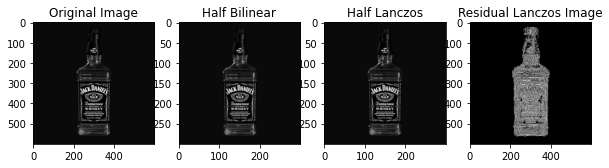

In [2]:
im_original         = Image.open("jack.jpg").convert('L')

im_half_bilinear    = im_original.resize((int(im_original.width/2),int(im_original.height/2)),Image.BILINEAR)
im_half_lanczos     = im_original.resize((int(im_original.width/2),int(im_original.height/2)),Image.LANCZOS)

zoom_im_lanczos     = im_half_lanczos.resize((int(im_original.width),int(im_original.height)),Image.LANCZOS)
zoom_im_bilinear    = im_half_bilinear.resize((int(im_original.width),int(im_original.height)),Image.BILINEAR)

original_image      = np.array(im_original)
half_image_lanczos  = np.array(zoom_im_lanczos)
half_image_bilinear = np.array(zoom_im_bilinear)

residual_lanczos    = original_image - half_image_lanczos
residual_bilinear   = original_image - half_image_bilinear

loss_mse_lanczos    = ((residual_lanczos)**2).mean(axis=None)
loss_mse_bilinear   = ((residual_bilinear)**2).mean(axis=None)

print("Loss MSE LANCZOS: {}\nLOss MSE BILINEAR: {}".format(loss_mse_lanczos,loss_mse_bilinear))

f, axes = plt.subplots(1, 4, figsize=(10,10))

axes[0].imshow(im_original,cmap=plt.cm.gray)
axes[0].set_title('Original Image')
axes[1].imshow(im_half_bilinear,cmap=plt.cm.gray)
axes[1].set_title('Half Bilinear')
axes[2].imshow(im_half_lanczos,cmap=plt.cm.gray)
axes[2].set_title('Half Lanczos')
axes[3].imshow(residual_lanczos,cmap=plt.cm.gray)
axes[3].set_title('Residual Lanczos Image')


# Gaussian Pyramid

In [3]:
img = cv2.imread("./jack.jpg", 0)

In [4]:
def downscale(_image):
  new_w = np.int(_image.shape[0]/2)
  new_h = np.int(_image.shape[1]/2)
  #the image that will store the data
  #initial with all 0
  new_image = np.zeros(shape=(new_w,new_h))

  new_image_index_row     = -1
  new_image_index_column  = -1

  for i, row in enumerate(_image):
    #only the even
    if i % 2 == 0:
      
      new_image_index_row += 1
      for j,column in enumerate(row):
        #only the even
        if j % 2 == 0:
          
          new_image_index_column += 1
          new_image[new_image_index_row,new_image_index_column] = _image[i,j]

      new_image_index_column = -1

      
  return new_image

Now we start to decrease the size of image:

*   The first resize is the half of the original size
*   And then a quarter of the original size


In [5]:
half_original_image_blur          = cv2.GaussianBlur(img,(3,3),0)
residual_original_image           = cv2.subtract(img,half_original_image_blur)
half_original_image               = downscale(half_original_image_blur)

quarter_original_image_blur       = cv2.GaussianBlur(half_original_image,(3,3),0)
residual_half_original_image      = cv2.subtract(half_original_image,quarter_original_image_blur)
quarter_original_image            = downscale(quarter_original_image_blur)

In [6]:
quarter_to_haft_upsample          = cv2.pyrUp(quarter_original_image,dstsize=(quarter_original_image.shape[0]*2,quarter_original_image.shape[1]*2))
quarter_to_half_add_residual      = quarter_to_haft_upsample + residual_half_original_image

half_to_original_upsample         = cv2.pyrUp(quarter_to_half_add_residual,dstsize=(quarter_to_half_add_residual.shape[0]*2,quarter_to_half_add_residual.shape[1]*2))
half_to_original_add_residual     = half_to_original_upsample + residual_original_image

Show all the images

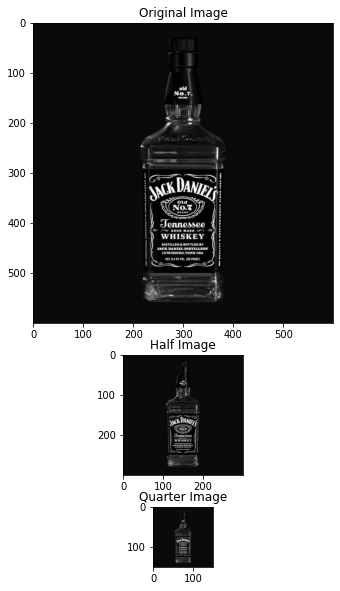

In [7]:
f, axes = plt.subplots(3, 1, figsize=(10,10))

axes[0].imshow(img,cmap=plt.cm.gray)
axes[0].set_title('Original Image')
axes[1].imshow(half_original_image,cmap=plt.cm.gray)
axes[1].set_title('Half Image')
axes[2].imshow(quarter_original_image,cmap=plt.cm.gray)
axes[2].set_title('Quarter Image')

# adjust subplot sizes
gs = GridSpec(3, 1, height_ratios=[5, 2, 1])
for i in range(3):
    axes[i].set_position(gs[i].get_position(f))

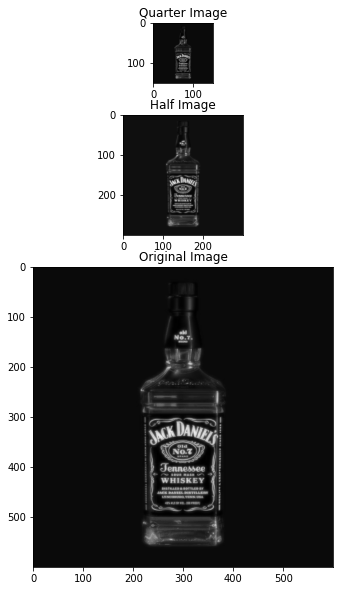

In [8]:
f, axes = plt.subplots(3, 1, figsize=(10,10))

axes[0].imshow(quarter_original_image,cmap=plt.cm.gray)
axes[0].set_title('Quarter Image')
axes[1].imshow(quarter_to_half_add_residual,cmap=plt.cm.gray)
axes[1].set_title('Half Image')
axes[2].imshow(half_to_original_add_residual,cmap=plt.cm.gray)
axes[2].set_title('Original Image')

# adjust subplot sizes
gs = GridSpec(3, 1, height_ratios=[1, 2, 5])
for i in range(3):
    axes[i].set_position(gs[i].get_position(f))

##MSE Gaussian Pyramid

In [9]:
loss_mse = ((img - half_to_original_add_residual)**2).mean(axis=None)
print(loss_mse)

129.95307458221845


#MIPMAP

Text(0.5, 1.0, 'Quarter Image')

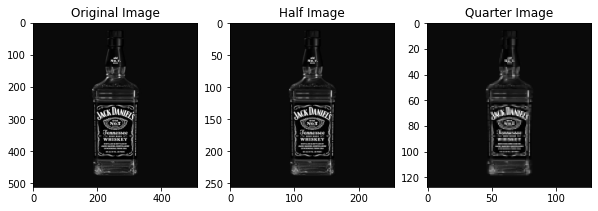

In [10]:
from __future__ import division
import numpy as np
from PIL import Image

def halve_image(image) :
    rows, cols = image.shape
    image = image.astype('uint16')
    image = image.reshape(rows // 2, 2, cols // 2, 2)
    image = image.sum(axis=3).sum(axis=1)
    return ((image + 2) >> 2).astype('uint8')

def mipmap(image,resize_value) :
    img = image.copy()
    rows, cols = image.shape
    mipmap = np.zeros((rows, cols * 3 // 2), dtype='uint8')
    # mipmap[:, :cols, :] = img
    row = 0
    counter = 0
    resize_value /= 2
    while counter < resize_value:
        img = halve_image(img)
        counter += 1
    return img

img = Image.open('jack.jpg').convert("L")
img = img.resize((512,512))
img = np.array(img)

half_img = mipmap(img,2)
quarter_img = mipmap(img,4)


f, axes = plt.subplots(1, 3, figsize=(10,10))

axes[0].imshow(img,cmap=plt.cm.gray)
axes[0].set_title('Original Image')
axes[1].imshow(half_img,cmap=plt.cm.gray)
axes[1].set_title('Half Image')
axes[2].imshow(quarter_img,cmap=plt.cm.gray)
axes[2].set_title('Quarter Image')

In [11]:
from_quarter_to_half = None
from_quarter_to_half = cv2.pyrUp(quarter_img)

from_half_to_original = None
from_half_to_original = cv2.pyrUp(from_quarter_to_half)

Text(0.5, 1.0, 'Quarter to Original Zoom Image')

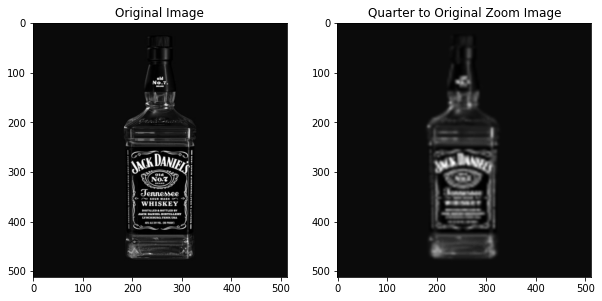

In [12]:
f, axes = plt.subplots(1, 2, figsize=(10,10))

axes[0].imshow(img,cmap=plt.cm.gray)
axes[0].set_title('Original Image')
axes[1].imshow(from_half_to_original,cmap=plt.cm.gray)
axes[1].set_title('Quarter to Original Zoom Image')


##MSE MIPMAP

In [13]:
loss_mse = ((img - from_half_to_original)**2).mean(axis=None)
print(loss_mse)

16.553199768066406
